# Quantum Resource Modeling for Protein Simulation using QMProt

## Context: Supporting the Paper
**Associated paper:**  
**"Quantum Strategy for the Simulation of Large Proteins: From Fragmentation in Small Proteins to Scalability in Complex Systems"**  
*Parfait Atchade-Adelomou & Laia Coronas Sala (2025)*

This notebook supports the research by providing data-driven models to estimate quantum resource demands for the simulation of fragmented biomolecules such as amino acids and peptides. It contributes to evaluating the **scalability and fault-tolerant feasibility** of simulating large biomolecules via **fragmentation and reassembly**.


## Objective

The notebook develops **predictive models** that estimate:

- The number of **qubits** required per fragment.
- The number of **Hamiltonian coefficients**.
- The **Toffoli gate count** (via extrapolation using SelectSwap).

This is done using the curated **QMProt dataset**, which includes 45 molecules representing the 20 essential amino acids and their structural groups.


## Methodology

### 1. Dataset Preparation
- Loads the QMProt dataset (`QMProt.json`), which contains:
  - `n_electrons`
  - `n_qubits`
  - `n_coefficients`

### 2. Preprocessing
- Filters entries with zero values.
- Defines predictors and targets:
  - **Input (X):** Electron count.
  - **Targets (y):** Qubits and coefficients.

### 3. Regression Modeling
- Linear and non-linear regressions.
- Curve fitting using `scipy.optimize.curve_fit`.
- Evaluation via MAE, RMSE, and residuals.

### 4. Estimations and Implications
- Models extrapolate resource demands for larger systems.
- Enable prediction of Toffoli counts in the full pipeline.
- Support error estimation under fragmentation strategy.


## Why It Matters

These models are crucial for:

- **Scalability Assessment:** Predict quantum cost for fragments derived from large proteins (e.g., glucagon, 1852 electrons).
- **Benchmarking Fault-Tolerance Readiness:** Estimate Toffoli count for QEC planning.
- **Validation of Fragmentation Strategy:** Check efficiency vs. monolithic simulation (validated gains up to 10²⁰ gate reduction).


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


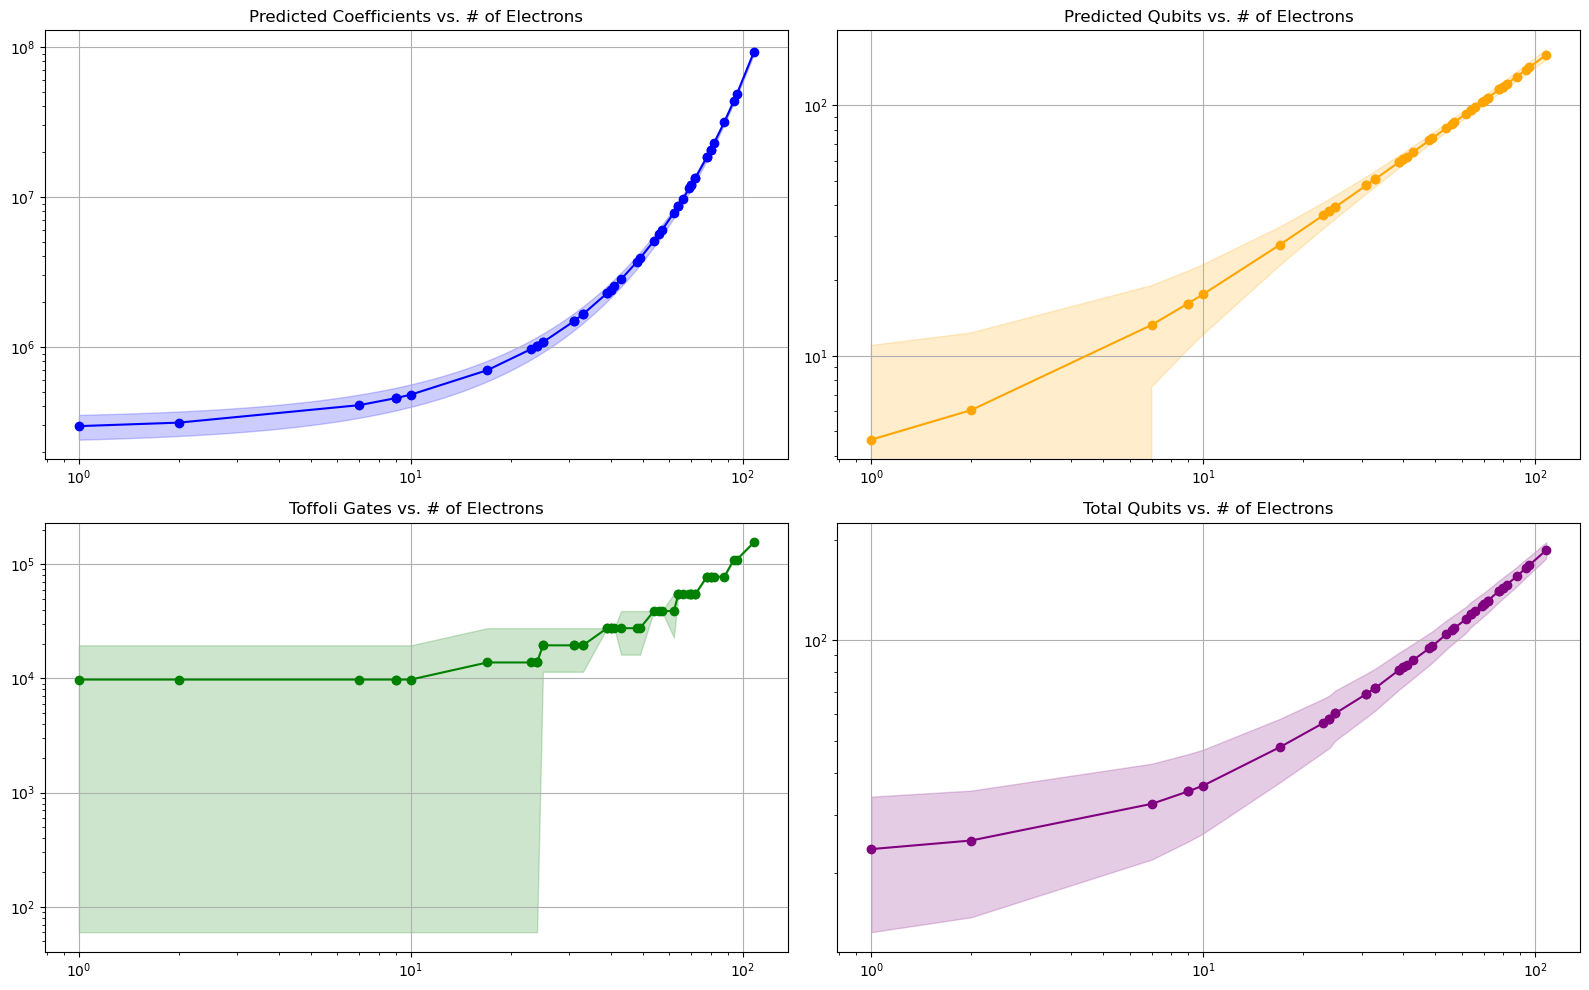

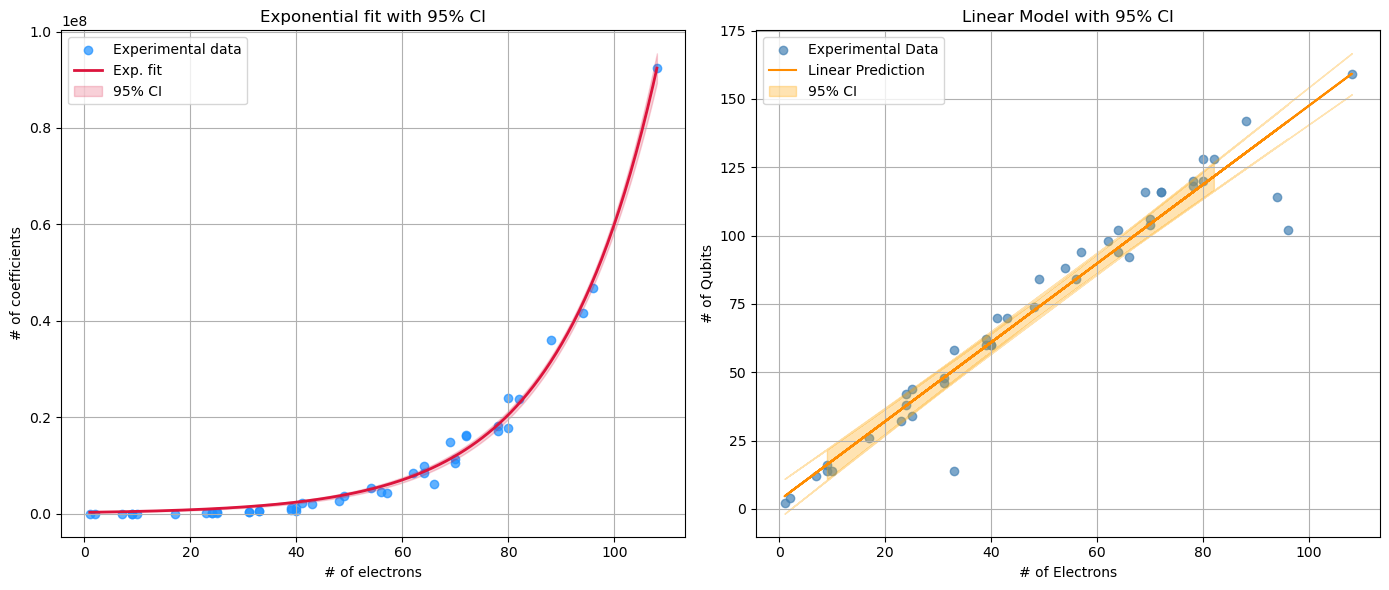

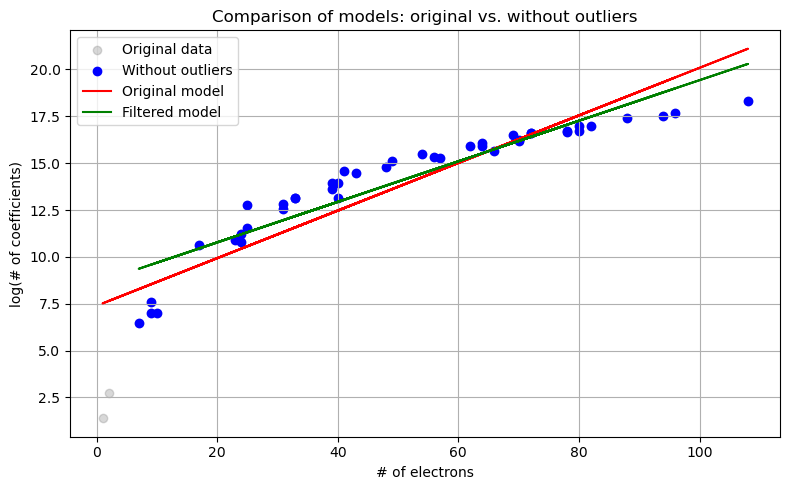


Summary of results:
Log-exp model (filtered) R²: 0.811
Log-exp CV R²: train = 0.871, test = 0.772
RMSE (test set): 0.841 | MAE: 0.753
Standard deviation (coefficients): 1590196.13 (15.87%)

Linear model (qubits) R²: 0.937
Qubit CV R²: train = 0.930, test = 0.982
RMSE (qubits test): 4.356 | MAE: 3.820
Standard deviation (qubits): 10.31 (13.96%)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline
import json
import scipy.stats as stats

# === Load and extract data ===
with open("QMProt.json", "r") as f:
    qm_data = json.load(f)

def extract_data(mols):
    return [(m["n_electrons"], m["n_qubits"], m["n_coefficients"]) 
            for m in mols if m["n_qubits"] > 0 and m["n_coefficients"] > 0]

data = extract_data(qm_data["amino_acids"]) + extract_data(qm_data.get("other_molecules", []))
electrons, qubits, coeffs = zip(*data)
X_qm = np.array(electrons)
y_qubits_qm = np.array(qubits)
y_coef_qm = np.array(coeffs)

# === Regression models ===
def func_exp(x, a, b): return a * np.exp(b * x)

# Logarithmic transformation for exponential model
log_y_coef = np.log(y_coef_qm)
X_const = sm.add_constant(X_qm)
model_logexp = sm.OLS(log_y_coef, X_const).fit()
res = log_y_coef - model_logexp.predict(X_const)

# Outlier removal based on Z-score threshold
mask = np.abs((res - res.mean()) / res.std()) < 2.5
X_filtered = X_qm[mask]
y_filtered_log = log_y_coef[mask]
X_filtered_const = sm.add_constant(X_filtered)
model_filtered = sm.OLS(y_filtered_log, X_filtered_const).fit()

# Cross-validation for coefficients model
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_filtered.reshape(-1, 1), y_filtered_log, test_size=0.2, random_state=42)
logexp_cv = LinearRegression().fit(Xf_train, yf_train)
r2_train_f = logexp_cv.score(Xf_train, yf_train)
r2_test_f = logexp_cv.score(Xf_test, yf_test)
rmse_f = mean_squared_error(yf_test, logexp_cv.predict(Xf_test), squared=False)
mae_f = mean_absolute_error(yf_test, logexp_cv.predict(Xf_test))

# 95% Confidence intervals for linear model (qubits)
modelo_qubits = LinearRegression().fit(X_qm.reshape(-1, 1), y_qubits_qm)
y_qubits_pred = modelo_qubits.predict(X_qm.reshape(-1, 1))
resid_qubits = y_qubits_qm - y_qubits_pred
se_fit = np.sqrt(np.sum(resid_qubits**2) / (len(X_qm) - 2))
t_val = stats.t.ppf(0.975, df=len(X_qm)-2)
ci_qubits = t_val * se_fit * np.sqrt(1/len(X_qm) + ((X_qm - np.mean(X_qm))**2) / np.sum((X_qm - np.mean(X_qm))**2))

# Cross-validation for qubit model
Xq_train, Xq_test, yq_train, yq_test = train_test_split(X_qm.reshape(-1, 1), y_qubits_qm, test_size=0.2, random_state=42)
r2_q_train = modelo_qubits.score(Xq_train, yq_train)
r2_q_test = modelo_qubits.score(Xq_test, yq_test)
rmse_q = mean_squared_error(yq_test, modelo_qubits.predict(Xq_test), squared=False)
mae_q = mean_absolute_error(yq_test, modelo_qubits.predict(Xq_test))

# Curve fitting and standard deviations
popt, pcov = curve_fit(func_exp, X_qm, y_coef_qm, p0=(1e5, 0.05))
std_exp = np.std(y_coef_qm - func_exp(X_qm, *popt))
std_lin = np.std(resid_qubits)

# 95% Confidence intervals for exponential fit
alpha = 0.05
n = len(X_qm)
X_pred = np.linspace(min(X_qm), max(X_qm), 300)
Y_pred = func_exp(X_pred, *popt)
J = np.zeros((len(X_pred), 2))
J[:, 0] = np.exp(popt[1] * X_pred)
J[:, 1] = popt[0] * X_pred * np.exp(popt[1] * X_pred)
var_pred = np.sum(J @ pcov * J, axis=1)
y_err = stats.t.ppf(1 - alpha / 2, df=n - 2) * np.sqrt(var_pred)

# DataFrame with predictions and deviations
df_pred = pd.DataFrame({
    "n_electrons": X_qm,
    "n_coefficients": y_coef_qm,
    "n_qubits": y_qubits_qm,
})
df_pred["Predicted Coefficients"] = func_exp(df_pred["n_electrons"], *popt)
df_pred["Predicted Qubits"] = y_qubits_pred
df_pred["std_coefficients"] = std_exp
df_pred["std_qubits"] = std_lin
df_pred["qubit_ci_lower"] = df_pred["Predicted Qubits"] - ci_qubits
df_pred["qubit_ci_upper"] = df_pred["Predicted Qubits"] + ci_qubits

# Toffoli gate estimation function
def calculate_toffoli(n_terms):
    if n_terms <= 0:
        return 0
    n = np.log2(n_terms)
    n = np.ceil(n)
    epsilon = n / (2 ** 20)
    log_term = np.log2(n / epsilon)
    return 3 * (np.sqrt((2 ** n) * log_term) + log_term)

df_pred["Toffoli Gates"] = df_pred["Predicted Coefficients"].apply(calculate_toffoli)
df_pred["std_toffoli"] = df_pred["Predicted Coefficients"].apply(lambda x: calculate_toffoli(x + std_exp) - calculate_toffoli(x))
df_pred["QPE Qubits"] = df_pred["Predicted Coefficients"].apply(lambda x: np.ceil(np.log2(x)) if x > 0 else 0)
df_pred["Total Qubits"] = df_pred["Predicted Qubits"] + df_pred["QPE Qubits"]
df_pred["std_total_qubits"] = std_lin + df_pred["Predicted Coefficients"].apply(lambda x: (np.log(2) / (x * np.log(2))) if x > 0 else 0)

df_pred = df_pred.sort_values("n_electrons").reset_index(drop=True)

# === Final plots with CI ===
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
x = df_pred["n_electrons"]

axs[0, 0].plot(x, df_pred["Predicted Coefficients"], color="blue", marker='o')
axs[0, 0].fill_between(X_pred, Y_pred - y_err, Y_pred + y_err, color="blue", alpha=0.2)
axs[0, 0].set_xscale("log")
axs[0, 0].set_yscale("log")
axs[0, 0].set_title("Predicted Coefficients vs. # of Electrons")
axs[0, 0].grid(True)

axs[0, 1].plot(x, df_pred["Predicted Qubits"], color="orange", marker='o')
axs[0, 1].fill_between(x, df_pred["qubit_ci_lower"], df_pred["qubit_ci_upper"], color="orange", alpha=0.2)
axs[0, 1].set_xscale("log")
axs[0, 1].set_yscale("log")
axs[0, 1].set_title("Predicted Qubits vs. # of Electrons")
axs[0, 1].grid(True)

axs[1, 0].plot(x, df_pred["Toffoli Gates"], color="green", marker='o')
axs[1, 0].fill_between(x, df_pred["Toffoli Gates"] - df_pred["std_toffoli"], df_pred["Toffoli Gates"] + df_pred["std_toffoli"], color="green", alpha=0.2)
axs[1, 0].set_xscale("log")
axs[1, 0].set_yscale("log")
axs[1, 0].set_title("Toffoli Gates vs. # of Electrons")
axs[1, 0].grid(True)

axs[1, 1].plot(x, df_pred["Total Qubits"], color="purple", marker='o')
axs[1, 1].fill_between(x, df_pred["Total Qubits"] - df_pred["std_total_qubits"], df_pred["Total Qubits"] + df_pred["std_total_qubits"], color="purple", alpha=0.2)
axs[1, 1].set_xscale("log")
axs[1, 1].set_yscale("log")
axs[1, 1].set_title("Total Qubits vs. # of Electrons")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# === Additional plots: basic CI ===
plt.figure(figsize=(14, 6))

# Percent deviation for coefficients
std_exp = np.std(y_coef_qm - func_exp(X_qm, *popt))
mean_coef = np.mean(y_coef_qm)
std_exp_pct = 100 * std_exp / mean_coef
std_lin_pct = 100 * std_lin / np.mean(y_qubits_qm)

# Exponential fit with 95% CI
plt.subplot(1, 2, 1)
plt.scatter(X_qm, y_coef_qm, color="dodgerblue", alpha=0.7, label="Experimental data")
plt.plot(X_pred, Y_pred, color="crimson", label="Exp. fit", linewidth=2)
plt.fill_between(X_pred, Y_pred - y_err, Y_pred + y_err, color="crimson", alpha=0.2, label="95% CI")
plt.xlabel("# of electrons")
plt.ylabel("# of coefficients")
plt.title("Exponential fit with 95% CI")
plt.legend()
plt.grid(True)

# Linear fit with 95% CI
plt.subplot(1, 2, 2)
plt.scatter(X_qm, y_qubits_qm, color="steelblue", alpha=0.7, label="Experimental Data")
plt.plot(X_qm, y_qubits_pred, color="darkorange", label="Linear Prediction")
plt.fill_between(X_qm, y_qubits_pred - ci_qubits, y_qubits_pred + ci_qubits, color="orange", alpha=0.3, label="95% CI")
plt.xlabel("# of Electrons")
plt.ylabel("# of Qubits")
plt.title("Linear Model with 95% CI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Model comparison: original vs filtered ===
plt.figure(figsize=(8, 5))
plt.scatter(X_qm, log_y_coef, color="gray", label="Original data", alpha=0.3)
plt.scatter(X_filtered, y_filtered_log, color="blue", label="Without outliers")
plt.plot(X_qm, model_logexp.predict(X_const), color="red", label="Original model")
plt.plot(X_filtered, model_filtered.predict(X_filtered_const), color="green", label="Filtered model")
plt.xlabel("# of electrons")
plt.ylabel("log(# of coefficients)")
plt.title("Comparison of models: original vs. without outliers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Summary of results ===
print("\nSummary of results:")
print(f"Log-exp model (filtered) R²: {model_logexp.rsquared:.3f}")
print(f"Log-exp CV R²: train = {r2_train_f:.3f}, test = {r2_test_f:.3f}")
print(f"RMSE (test set): {rmse_f:.3f} | MAE: {mae_f:.3f}")
print(f"Standard deviation (coefficients): {std_exp:.2f} ({std_exp_pct:.2f}%)")
print(f"\nLinear model (qubits) R²: {modelo_qubits.score(X_qm.reshape(-1, 1), y_qubits_qm):.3f}")
print(f"Qubit CV R²: train = {r2_q_train:.3f}, test = {r2_q_test:.3f}")
print(f"RMSE (qubits test): {rmse_q:.3f} | MAE: {mae_q:.3f}")
print(f"Standard deviation (qubits): {np.std(resid_qubits):.2f} ({std_lin_pct:.2f}%)")


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/jovyan/work/ipykernel_20155/1393641627.py:32: RuntimeWarning: overflow encountered in exp
  def func_exp(x, a, b): return a * np.exp(b * x)


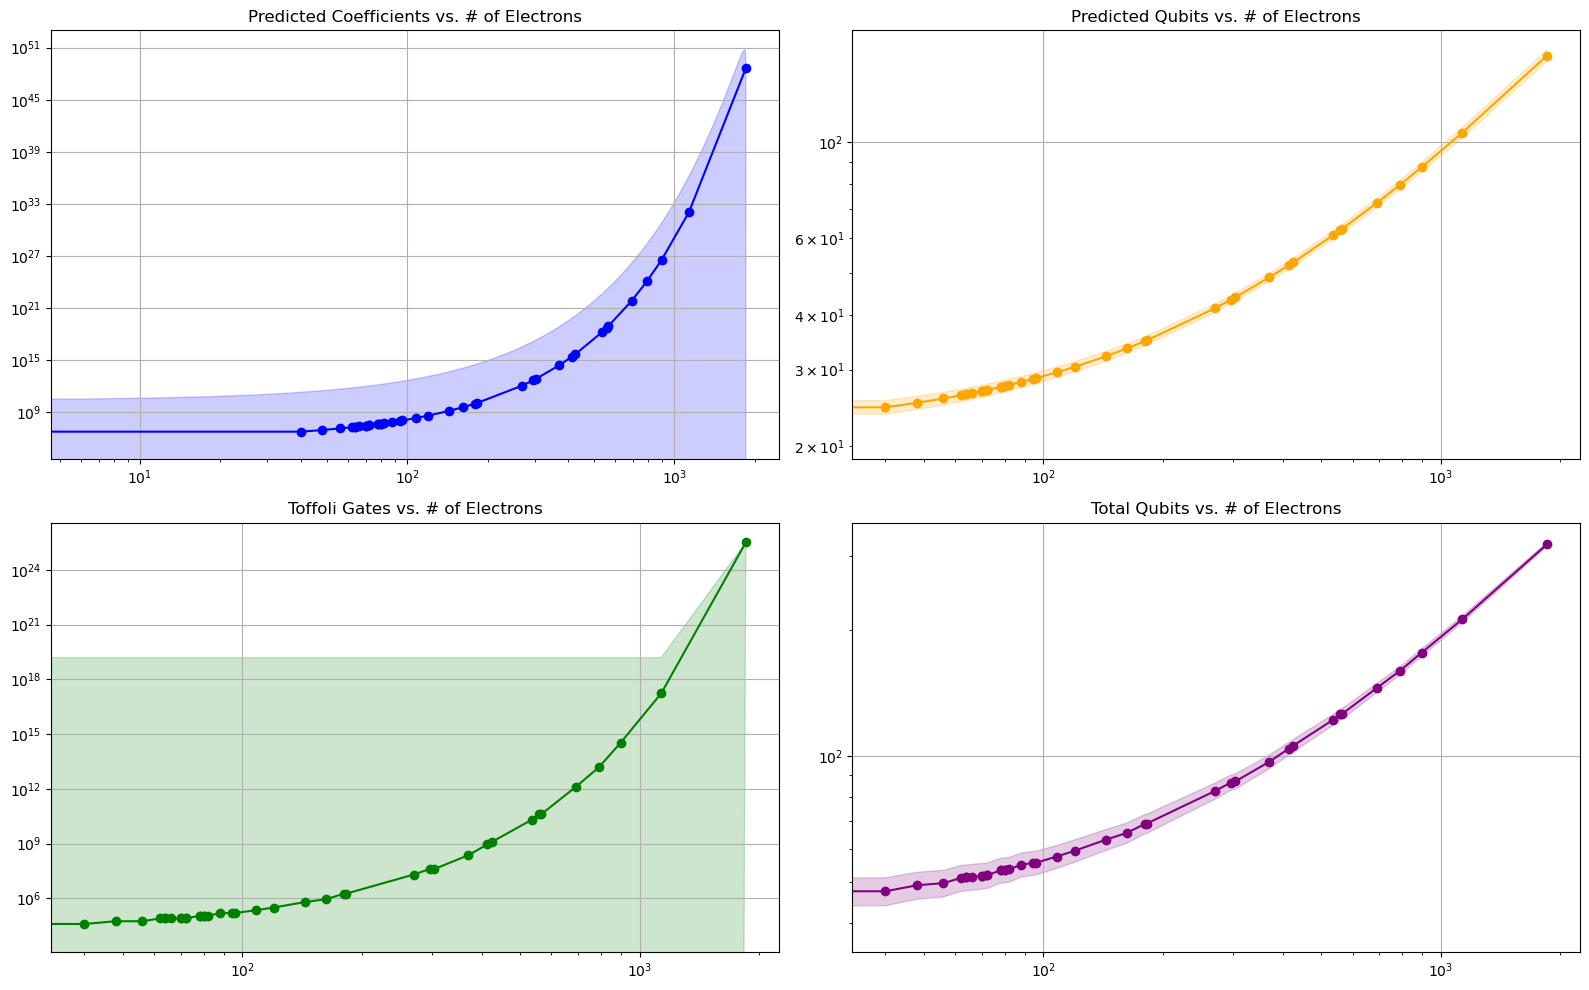

<Figure size 1400x600 with 0 Axes>

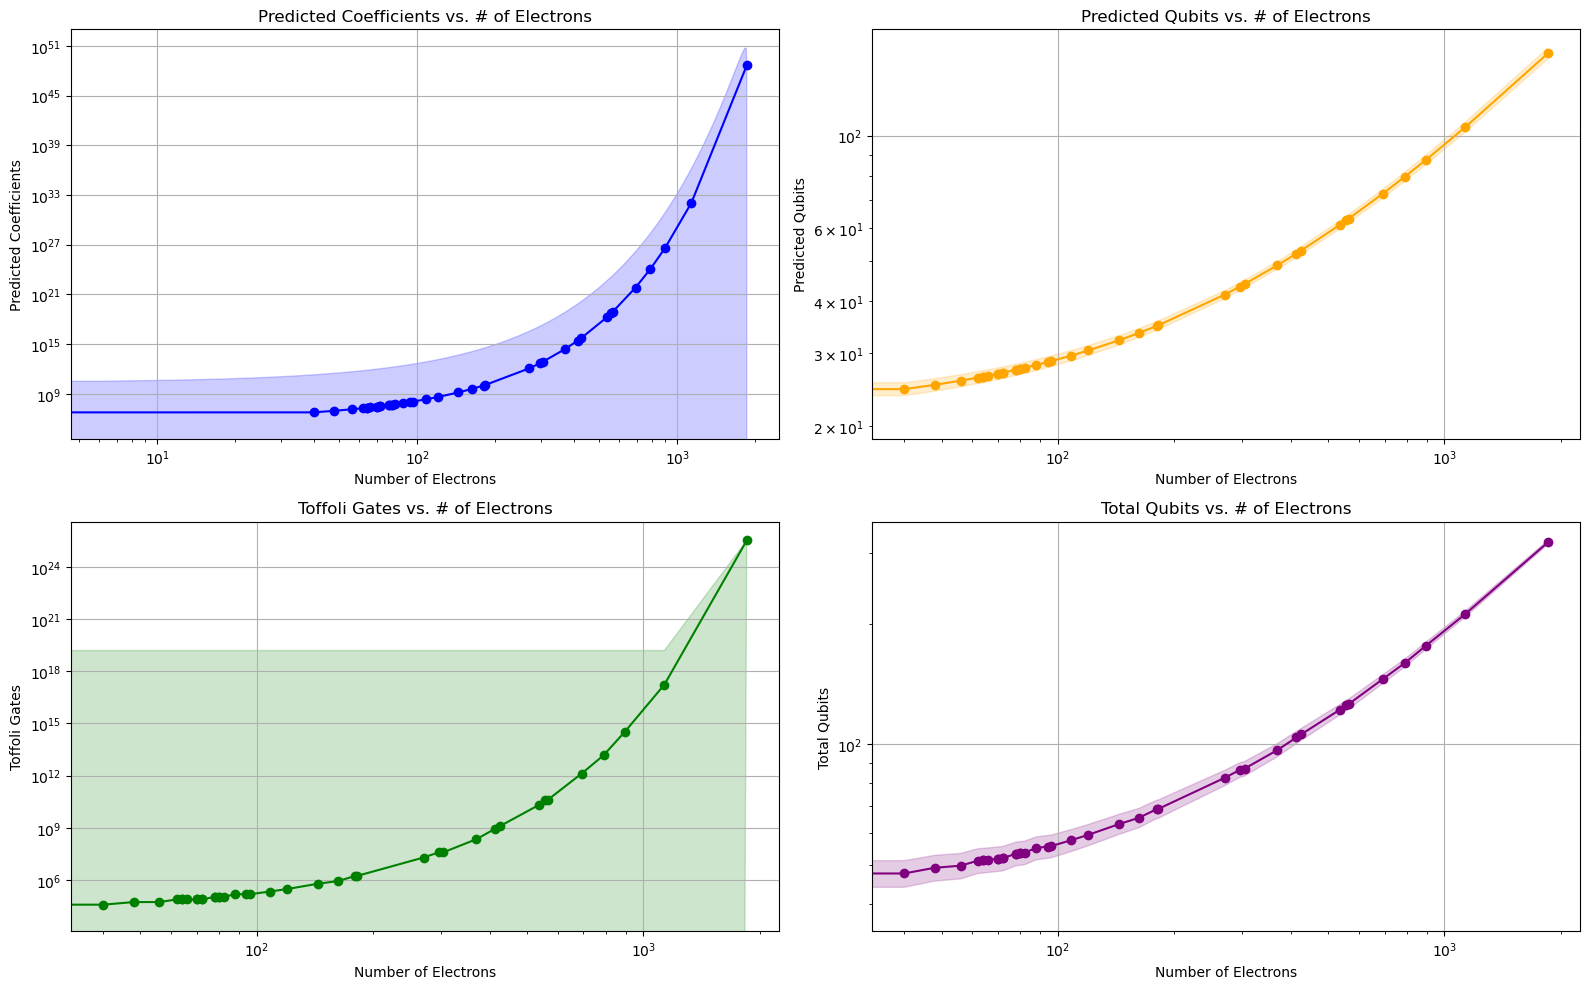


Summary of results:
Log-exp model (filtered) R²: 0.973
Log-exp CV R²: train = 0.972, test = 0.976
RMSE (test set): 2.436 | MAE: 2.240
Standard deviation (coefficients): 728776516985144362543487575299981312.00 (0.00%)

Linear model (qubits) R²: 0.973
Qubit CV R²: train = 0.972, test = 0.976
RMSE (qubits test): 3.430 | MAE: 3.021
Standard deviation (qubits): 3.64 (11.24%)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline
import json
import scipy.stats as stats

# === Load and extract data ===
with open("Molecule_Metrics_Recalculated_QMProt_Format.json", "r") as f:
    qm_data = json.load(f)

def extract_data(mols):
    return [(m["n_electrons"], m["n_qubits"], m["n_coefficients"]) 
            for m in mols if m["n_qubits"] > 0 and m["n_coefficients"] > 0]

data = extract_data(qm_data["amino_acids"]) + extract_data(qm_data.get("other_molecules", []))
electrons, qubits, coeffs = zip(*data)
#X_qm = np.array(electrons)
#y_qubits_qm = np.array(qubits)
#y_coef_qm = np.array(coeffs)

X_qm = np.array(electrons, dtype=np.float64)
y_qubits_qm = np.array(qubits, dtype=np.float64)
y_coef_qm = np.array(coeffs, dtype=np.float64)

# === Regression models ===
def func_exp(x, a, b): return a * np.exp(b * x)

# Logarithmic transformation for exponential model
log_y_coef = np.log(y_coef_qm)
X_const = sm.add_constant(X_qm)
model_logexp = sm.OLS(log_y_coef, X_const).fit()
res = log_y_coef - model_logexp.predict(X_const)




# Outlier removal based on Z-score threshold
mask = np.abs((res - res.mean()) / res.std()) < 2.5
X_filtered = X_qm[mask]
y_filtered_log = log_y_coef[mask]
X_filtered_const = sm.add_constant(X_filtered)
model_filtered = sm.OLS(y_filtered_log, X_filtered_const).fit()

# Cross-validation for coefficients model
Xf_train, Xf_test, yf_train, yf_test = train_test_split(X_filtered.reshape(-1, 1), y_filtered_log, test_size=0.2, random_state=42)
logexp_cv = LinearRegression().fit(Xf_train, yf_train)
r2_train_f = logexp_cv.score(Xf_train, yf_train)
r2_test_f = logexp_cv.score(Xf_test, yf_test)
rmse_f = mean_squared_error(yf_test, logexp_cv.predict(Xf_test), squared=False)
mae_f = mean_absolute_error(yf_test, logexp_cv.predict(Xf_test))

# 95% Confidence intervals for linear model (qubits)
modelo_qubits = LinearRegression().fit(X_qm.reshape(-1, 1), y_qubits_qm)
y_qubits_pred = modelo_qubits.predict(X_qm.reshape(-1, 1))
resid_qubits = y_qubits_qm - y_qubits_pred
se_fit = np.sqrt(np.sum(resid_qubits**2) / (len(X_qm) - 2))
t_val = stats.t.ppf(0.975, df=len(X_qm)-2)
ci_qubits = t_val * se_fit * np.sqrt(1/len(X_qm) + ((X_qm - np.mean(X_qm))**2) / np.sum((X_qm - np.mean(X_qm))**2))

# Cross-validation for qubit model
Xq_train, Xq_test, yq_train, yq_test = train_test_split(X_qm.reshape(-1, 1), y_qubits_qm, test_size=0.2, random_state=42)
r2_q_train = modelo_qubits.score(Xq_train, yq_train)
r2_q_test = modelo_qubits.score(Xq_test, yq_test)
rmse_q = mean_squared_error(yq_test, modelo_qubits.predict(Xq_test), squared=False)
mae_q = mean_absolute_error(yq_test, modelo_qubits.predict(Xq_test))

# Curve fitting and standard deviations
popt, pcov = curve_fit(func_exp, X_qm, y_coef_qm, p0=(1e5, 0.05))
std_exp = np.std(y_coef_qm - func_exp(X_qm, *popt))
std_lin = np.std(resid_qubits)

# 95% Confidence intervals for exponential fit
alpha = 0.05
n = len(X_qm)
X_pred = np.linspace(min(X_qm), max(X_qm), 300)
Y_pred = func_exp(X_pred, *popt)
J = np.zeros((len(X_pred), 2))
J[:, 0] = np.exp(popt[1] * X_pred)
J[:, 1] = popt[0] * X_pred * np.exp(popt[1] * X_pred)
var_pred = np.sum(J @ pcov * J, axis=1)
y_err = stats.t.ppf(1 - alpha / 2, df=n - 2) * np.sqrt(var_pred)

# DataFrame with predictions and deviations
df_pred = pd.DataFrame({
    "n_electrons": X_qm,
    "n_coefficients": y_coef_qm,
    "n_qubits": y_qubits_qm,
})
df_pred["Predicted Coefficients"] = func_exp(df_pred["n_electrons"], *popt)
df_pred["Predicted Qubits"] = y_qubits_pred
df_pred["std_coefficients"] = std_exp
df_pred["std_qubits"] = std_lin
df_pred["qubit_ci_lower"] = df_pred["Predicted Qubits"] - ci_qubits
df_pred["qubit_ci_upper"] = df_pred["Predicted Qubits"] + ci_qubits

# Toffoli gate estimation function
def calculate_toffoli(n_terms):
    if n_terms <= 0:
        return 0
    n = np.log2(n_terms)
    n = np.ceil(n)
    epsilon = n / (2 ** 20)
    log_term = np.log2(n / epsilon)
    return 3 * (np.sqrt((2 ** n) * log_term) + log_term)

df_pred["Toffoli Gates"] = df_pred["Predicted Coefficients"].apply(calculate_toffoli)
df_pred["std_toffoli"] = df_pred["Predicted Coefficients"].apply(lambda x: calculate_toffoli(x + std_exp) - calculate_toffoli(x))
df_pred["QPE Qubits"] = df_pred["Predicted Coefficients"].apply(lambda x: np.ceil(np.log2(x)) if x > 0 else 0)
df_pred["Total Qubits"] = df_pred["Predicted Qubits"] + df_pred["QPE Qubits"]
df_pred["std_total_qubits"] = std_lin + df_pred["Predicted Coefficients"].apply(lambda x: (np.log(2) / (x * np.log(2))) if x > 0 else 0)

df_pred = df_pred.sort_values("n_electrons").reset_index(drop=True)

# === Final plots with CI ===
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
x = df_pred["n_electrons"]

axs[0, 0].plot(x, df_pred["Predicted Coefficients"], color="blue", marker='o')
axs[0, 0].fill_between(X_pred, Y_pred - y_err, Y_pred + y_err, color="blue", alpha=0.2)
axs[0, 0].set_xscale("log")
axs[0, 0].set_yscale("log")
axs[0, 0].set_title("Predicted Coefficients vs. # of Electrons")
axs[0, 0].grid(True)

axs[0, 1].plot(x, df_pred["Predicted Qubits"], color="orange", marker='o')
#axs[0, 1].fill_between(x, df_pred["qubit_ci_lower"], df_pred["qubit_ci_upper"], color="orange", alpha=0.2)
axs[0, 1].fill_between(x,
                      df_pred["qubit_ci_lower"].values,
                      df_pred["qubit_ci_upper"].values,
                      color="orange", alpha=0.2)


axs[0, 1].set_xscale("log")
axs[0, 1].set_yscale("log")
axs[0, 1].set_title("Predicted Qubits vs. # of Electrons")
axs[0, 1].grid(True)

axs[1, 0].plot(x, df_pred["Toffoli Gates"], color="green", marker='o')
axs[1, 0].fill_between(x, df_pred["Toffoli Gates"] - df_pred["std_toffoli"], df_pred["Toffoli Gates"] + df_pred["std_toffoli"], color="green", alpha=0.2)
axs[1, 0].set_xscale("log")
axs[1, 0].set_yscale("log")
axs[1, 0].set_title("Toffoli Gates vs. # of Electrons")
axs[1, 0].grid(True)

axs[1, 1].plot(x, df_pred["Total Qubits"], color="purple", marker='o')
axs[1, 1].fill_between(x, df_pred["Total Qubits"] - df_pred["std_total_qubits"], df_pred["Total Qubits"] + df_pred["std_total_qubits"], color="purple", alpha=0.2)
axs[1, 1].set_xscale("log")
axs[1, 1].set_yscale("log")
axs[1, 1].set_title("Total Qubits vs. # of Electrons")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# === Additional plots: basic CI ===
plt.figure(figsize=(14, 6))

# Percent deviation for coefficients
std_exp = np.std(y_coef_qm - func_exp(X_qm, *popt))
mean_coef = np.mean(y_coef_qm)
std_exp_pct = 100 * std_exp / mean_coef
std_lin_pct = 100 * std_lin / np.mean(y_qubits_qm)

# === Final plots with CI ===
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
x = df_pred["n_electrons"]

axs[0, 0].plot(x, df_pred["Predicted Coefficients"], color="blue", marker='o')
axs[0, 0].fill_between(X_pred, Y_pred - y_err, Y_pred + y_err, color="blue", alpha=0.2)
axs[0, 0].set_xscale("log")
axs[0, 0].set_yscale("log")
axs[0, 0].set_title("Predicted Coefficients vs. # of Electrons")
axs[0, 0].set_xlabel("Number of Electrons")
axs[0, 0].set_ylabel("Predicted Coefficients")
axs[0, 0].grid(True)

axs[0, 1].plot(x, df_pred["Predicted Qubits"], color="orange", marker='o')
axs[0, 1].fill_between(x,
                      df_pred["qubit_ci_lower"].values,
                      df_pred["qubit_ci_upper"].values,
                      color="orange", alpha=0.2)
axs[0, 1].set_xscale("log")
axs[0, 1].set_yscale("log")
axs[0, 1].set_title("Predicted Qubits vs. # of Electrons")
axs[0, 1].set_xlabel("Number of Electrons")
axs[0, 1].set_ylabel("Predicted Qubits")
axs[0, 1].grid(True)

axs[1, 0].plot(x, df_pred["Toffoli Gates"], color="green", marker='o')
axs[1, 0].fill_between(x, df_pred["Toffoli Gates"] - df_pred["std_toffoli"], df_pred["Toffoli Gates"] + df_pred["std_toffoli"], color="green", alpha=0.2)
axs[1, 0].set_xscale("log")
axs[1, 0].set_yscale("log")
axs[1, 0].set_title("Toffoli Gates vs. # of Electrons")
axs[1, 0].set_xlabel("Number of Electrons")
axs[1, 0].set_ylabel("Toffoli Gates")
axs[1, 0].grid(True)

axs[1, 1].plot(x, df_pred["Total Qubits"], color="purple", marker='o')
axs[1, 1].fill_between(x, df_pred["Total Qubits"] - df_pred["std_total_qubits"], df_pred["Total Qubits"] + df_pred["std_total_qubits"], color="purple", alpha=0.2)
axs[1, 1].set_xscale("log")
axs[1, 1].set_yscale("log")
axs[1, 1].set_title("Total Qubits vs. # of Electrons")
axs[1, 1].set_xlabel("Number of Electrons")
axs[1, 1].set_ylabel("Total Qubits")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


# === Summary of results ===
print("\nSummary of results:")
print(f"Log-exp model (filtered) R²: {model_logexp.rsquared:.3f}")
print(f"Log-exp CV R²: train = {r2_train_f:.3f}, test = {r2_test_f:.3f}")
print(f"RMSE (test set): {rmse_f:.3f} | MAE: {mae_f:.3f}")
print(f"Standard deviation (coefficients): {std_exp:.2f} ({std_exp_pct:.2f}%)")
print(f"\nLinear model (qubits) R²: {modelo_qubits.score(X_qm.reshape(-1, 1), y_qubits_qm):.3f}")
print(f"Qubit CV R²: train = {r2_q_train:.3f}, test = {r2_q_test:.3f}")
print(f"RMSE (qubits test): {rmse_q:.3f} | MAE: {mae_q:.3f}")
print(f"Standard deviation (qubits): {np.std(resid_qubits):.2f} ({std_lin_pct:.2f}%)")


/home/jovyan/work/ipykernel_20155/2721058334.py:27: RuntimeWarning: overflow encountered in exp
  def func_exp(x, a, b): return a * np.exp(b * x)


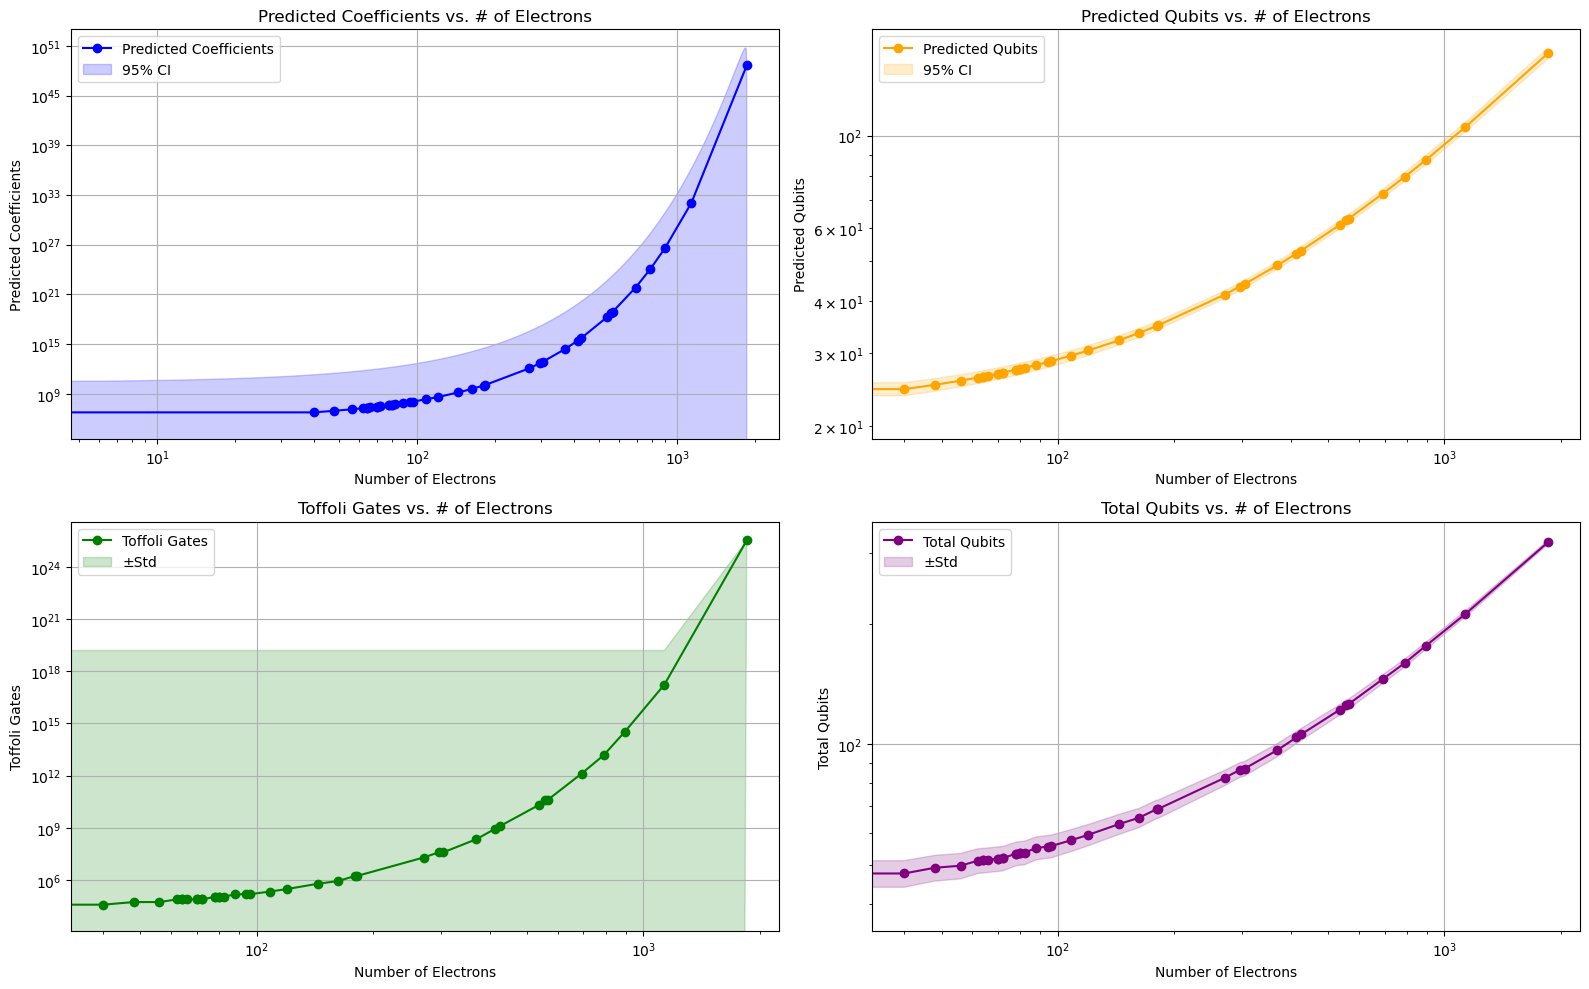

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.optimize import curve_fit
import json
import scipy.stats as stats

# === Load and extract data ===
with open("Molecule_Metrics_Recalculated_QMProt_Format.json", "r") as f:
    qm_data = json.load(f)

def extract_data(mols):
    return [(m["n_electrons"], m["n_qubits"], m["n_coefficients"]) 
            for m in mols if m["n_qubits"] > 0 and m["n_coefficients"] > 0]

data = extract_data(qm_data["amino_acids"]) + extract_data(qm_data.get("other_molecules", []))
electrons, qubits, coeffs = zip(*data)
X_qm = np.array(electrons, dtype=np.float64)
y_qubits_qm = np.array(qubits, dtype=np.float64)
y_coef_qm = np.array(coeffs, dtype=np.float64)

# === Exponential regression model for coefficients ===
def func_exp(x, a, b): return a * np.exp(b * x)

log_y_coef = np.log(y_coef_qm)
X_const = sm.add_constant(X_qm)
model_logexp = sm.OLS(log_y_coef, X_const).fit()
res = log_y_coef - model_logexp.predict(X_const)

# Remove outliers
mask = np.abs((res - res.mean()) / res.std()) < 2.5
X_filtered = X_qm[mask]
y_filtered_log = log_y_coef[mask]
X_filtered_const = sm.add_constant(X_filtered)
model_filtered = sm.OLS(y_filtered_log, X_filtered_const).fit()

# Curve fit (exponential)
popt, pcov = curve_fit(func_exp, X_qm, y_coef_qm, p0=(1e5, 0.05))
std_exp = np.std(y_coef_qm - func_exp(X_qm, *popt))

# === Linear regression model for qubits ===
modelo_qubits = LinearRegression().fit(X_qm.reshape(-1, 1), y_qubits_qm)
y_qubits_pred = modelo_qubits.predict(X_qm.reshape(-1, 1))
resid_qubits = y_qubits_qm - y_qubits_pred
se_fit = np.sqrt(np.sum(resid_qubits**2) / (len(X_qm) - 2))
t_val = stats.t.ppf(0.975, df=len(X_qm)-2)
ci_qubits = t_val * se_fit * np.sqrt(1/len(X_qm) + ((X_qm - np.mean(X_qm))**2) / np.sum((X_qm - np.mean(X_qm))**2))

# === Predictions and deviations ===
X_pred = np.linspace(min(X_qm), max(X_qm), 300)
Y_pred = func_exp(X_pred, *popt)
J = np.zeros((len(X_pred), 2))
J[:, 0] = np.exp(popt[1] * X_pred)
J[:, 1] = popt[0] * X_pred * np.exp(popt[1] * X_pred)
var_pred = np.sum(J @ pcov * J, axis=1)
y_err = stats.t.ppf(0.975, df=len(X_qm)-2) * np.sqrt(var_pred)

# === Build dataframe ===
df_pred = pd.DataFrame({
    "n_electrons": X_qm,
    "n_coefficients": y_coef_qm,
    "n_qubits": y_qubits_qm,
})
df_pred["Predicted Coefficients"] = func_exp(df_pred["n_electrons"], *popt)
df_pred["Predicted Qubits"] = y_qubits_pred
df_pred["std_coefficients"] = std_exp
df_pred["std_qubits"] = np.std(resid_qubits)
df_pred["qubit_ci_lower"] = df_pred["Predicted Qubits"] - ci_qubits
df_pred["qubit_ci_upper"] = df_pred["Predicted Qubits"] + ci_qubits

def calculate_toffoli(n_terms):
    if n_terms <= 0:
        return 0
    n = np.log2(n_terms)
    n = np.ceil(n)
    epsilon = n / (2 ** 20)
    log_term = np.log2(n / epsilon)
    return 3 * (np.sqrt((2 ** n) * log_term) + log_term)

df_pred["Toffoli Gates"] = df_pred["Predicted Coefficients"].apply(calculate_toffoli)
df_pred["std_toffoli"] = df_pred["Predicted Coefficients"].apply(lambda x: calculate_toffoli(x + std_exp) - calculate_toffoli(x))
df_pred["QPE Qubits"] = df_pred["Predicted Coefficients"].apply(lambda x: np.ceil(np.log2(x)) if x > 0 else 0)
df_pred["Total Qubits"] = df_pred["Predicted Qubits"] + df_pred["QPE Qubits"]
df_pred["std_total_qubits"] = df_pred["std_qubits"] + df_pred["Predicted Coefficients"].apply(lambda x: np.log(2) / x if x > 0 else 0)

df_pred = df_pred.sort_values("n_electrons").reset_index(drop=True)

# Convert to float for safe plotting
for col in ["qubit_ci_lower", "qubit_ci_upper", "std_toffoli", "std_total_qubits"]:
    df_pred[col] = pd.to_numeric(df_pred[col], errors="coerce")

# === Final plots ===
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
x = df_pred["n_electrons"]

axs[0, 0].plot(x, df_pred["Predicted Coefficients"], color="blue", marker='o', label="Predicted Coefficients")
axs[0, 0].fill_between(X_pred, Y_pred - y_err, Y_pred + y_err, color="blue", alpha=0.2, label="95% CI")
axs[0, 0].set_xscale("log")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("Number of Electrons")
axs[0, 0].set_ylabel("Predicted Coefficients")
axs[0, 0].set_title("Predicted Coefficients vs. # of Electrons")
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(x, df_pred["Predicted Qubits"], color="orange", marker='o', label="Predicted Qubits")
axs[0, 1].fill_between(x, df_pred["qubit_ci_lower"], df_pred["qubit_ci_upper"], color="orange", alpha=0.2, label="95% CI")
axs[0, 1].set_xscale("log")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("Number of Electrons")
axs[0, 1].set_ylabel("Predicted Qubits")
axs[0, 1].set_title("Predicted Qubits vs. # of Electrons")
axs[0, 1].legend()
axs[0, 1].grid(True)

axs[1, 0].plot(x, df_pred["Toffoli Gates"], color="green", marker='o', label="Toffoli Gates")
axs[1, 0].fill_between(x, df_pred["Toffoli Gates"] - df_pred["std_toffoli"], df_pred["Toffoli Gates"] + df_pred["std_toffoli"], color="green", alpha=0.2, label="±Std")
axs[1, 0].set_xscale("log")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("Number of Electrons")
axs[1, 0].set_ylabel("Toffoli Gates")
axs[1, 0].set_title("Toffoli Gates vs. # of Electrons")
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(x, df_pred["Total Qubits"], color="purple", marker='o', label="Total Qubits")
axs[1, 1].fill_between(x, df_pred["Total Qubits"] - df_pred["std_total_qubits"], df_pred["Total Qubits"] + df_pred["std_total_qubits"], color="purple", alpha=0.2, label="±Std")
axs[1, 1].set_xscale("log")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("Number of Electrons")
axs[1, 1].set_ylabel("Total Qubits")
axs[1, 1].set_title("Total Qubits vs. # of Electrons")
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()
